# **Clonando repositório iqoption e instalando pacote dotenv**

(https://iqoptionapi.github.io/iqoptionapi/)

(https://github.com/iqoptionapi/iqoptionapi)


In [1]:
# utilizando https

In [2]:
pip install -U git+https://github.com/iqoptionapi/iqoptionapi.git

  Cloning https://github.com/iqoptionapi/iqoptionapi.git to /tmp/pip-req-build-zkm673wv
  Running command git clone --filter=blob:none --quiet https://github.com/iqoptionapi/iqoptionapi.git /tmp/pip-req-build-zkm673wv
  Resolved https://github.com/iqoptionapi/iqoptionapi.git to commit 8a903cc094a74af1ed935a56a2d6b5a9ed3319d7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
  Created wheel for iqoptionapi: filename=iqoptionapi-7.1.1-py3-none-any.whl size=82016 sha256=dbaa1fad25423069958414a45b5a386d7115cea21082a5df014b7d57ff83ea0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-lew0tmuc/whe

In [3]:
pip install python-dotenv

# **Importando bibliotecas**

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from iqoptionapi.stable_api import IQ_Option
import time
import logging
import os
from dotenv import load_dotenv

# **Configurando tema dos plots**

In [5]:
from plotly.io import templates
templates.default = 'plotly_dark'

templates['plotly_dark'].layout.paper_bgcolor = '#383838'
templates['plotly_dark'].layout.plot_bgcolor = '#383838'

templates['plotly_dark'].layout.xaxis.gridcolor = '#D5D5D5'
templates['plotly_dark'].layout.xaxis.linecolor = '#D5D5D5'
templates['plotly_dark'].layout.xaxis.zerolinecolor = '#D5D5D5'

templates['plotly_dark'].layout.yaxis.gridcolor = '#D5D5D5'
templates['plotly_dark'].layout.yaxis.linecolor = '#D5D5D5'
templates['plotly_dark'].layout.yaxis.zerolinecolor = '#D5D5D5'

# **Definindo funções para plot com yfinance e iqoption**

(https://analyzingalpha.com/yfinance-python)

(https://www.investopedia.com/terms/r/rsi.asp)



In [6]:
# funcao para calculo do rsi utilizando 14 dias anteriores

In [7]:
def calculate_rsi(prices, period=14):

    delta = prices.diff()

    gain = delta.where(delta > 0, 0)

    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()

    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [8]:
# função para preencher as lacunas dos dados retornado pelo yfinance; api não retorna registros relativos a alguns dias

In [9]:
def preencher_lacunas(df):

    datas = pd.date_range(start=df.index.min(), end=df.index.max())


    df = df.reindex(datas)


    df = df.ffill()

    return df

In [10]:
# função para sinais de compra e venda de acordo com a passagem pelos limiares de venda(>= 70) ou compra(<= 30)
# a partir de posições anteriores de hold

In [11]:
def generate_signals(rsi_values):
    signals = []
    in_overbought = False
    in_oversold = False

    for rsi in rsi_values:

      if rsi > 30 and rsi < 70:

        signals.append('HOLD')

        in_overbought = False
        in_oversold = False

      elif rsi >= 70 and not in_overbought:

        signals.append('SELL')

        in_overbought = True

      elif rsi <= 30 and not in_oversold:

        signals.append('BUY')

        in_oversold = True

      else:

        signals.append('HOLD')

    return signals


In [12]:
# função para avalição da tendencia do mercado pois o indicador rsi atua melhor em mercados de range

In [13]:
def evaluate_market_trend(data):

    data['SMA_200'] = data['Close'].rolling(window=200).mean()

    data['RSI'] = calculate_rsi(data['Close'])

    data['Trend'] = 'Range'

    data.loc[(data['RSI'] > 30) & (data['RSI'] < 70), 'Trend'] = 'Range'

    return data

In [14]:
# funcao para realização da chamada de api, utilizando a funcao data_filled desenvolvida anteriormente para preencher lacunas nos registros

In [15]:
def get_historical_data(symbol, start_date, end_date):

    data = yf.download(symbol, start=start_date, end=end_date)

    data_filled = preencher_lacunas(data)

    return data_filled


# **Plots a partir do yfinance**

(https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh)

In [16]:
start_date = '2023-01-01'

In [17]:
end_date = '2023-07-20'

In [18]:
tsla_df = get_historical_data('TSLA', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [19]:
rsi_values = calculate_rsi(tsla_df['Close'])

In [20]:
rsi_values.head(14)

2023-01-03          NaN
2023-01-04          NaN
2023-01-05          NaN
2023-01-06          NaN
2023-01-07          NaN
2023-01-08          NaN
2023-01-09          NaN
2023-01-10          NaN
2023-01-11          NaN
2023-01-12          NaN
2023-01-13          NaN
2023-01-14          NaN
2023-01-15          NaN
2023-01-16    78.438027
Freq: D, Name: Close, dtype: float64

In [21]:
tsla_df['RSI'] = rsi_values

In [22]:
tsla_df[tsla_df.index == '2023-05-21']

,Open,High,Low,Close,Adj Close,Volume,RSI
2023-05-21,177.169998,181.949997,176.309998,180.139999,180.139999,136024200.0,64.044871


In [23]:
tsla_df['Signal'] = generate_signals(tsla_df['RSI'])

In [24]:
tsla_df = evaluate_market_trend(tsla_df)

In [25]:
tsla_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend
2023-07-15,277.010010,285.299988,276.309998,281.380005,281.380005,119771100.0,67.420274,HOLD,NaN,Range
2023-07-16,277.010010,285.299988,276.309998,281.380005,281.380005,119771100.0,67.420274,HOLD,NaN,Range
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600.0,73.117890,SELL,NaN,Range
2023-07-18,290.149994,295.260010,286.010010,293.339996,293.339996,112434700.0,74.685873,HOLD,NaN,Range
2023-07-19,296.040009,299.290009,289.519989,291.260010,291.260010,142355400.0,71.528598,HOLD,NaN,Range


In [26]:
tsla_df[tsla_df['RSI'] >= 70]['RSI']

2023-01-16    78.438027
2023-01-17    87.379984
2023-01-18    77.112587
2023-01-19    71.720787
2023-01-20    78.117355
                ...    
2023-07-04    71.860982
2023-07-05    72.994116
2023-07-17    73.117890
2023-07-18    74.685873
2023-07-19    71.528598
Name: RSI, Length: 66, dtype: float64

In [27]:
tsla_df[tsla_df['Signal'] == 'BUY']['RSI']

2023-04-20    26.92402
Freq: D, Name: RSI, dtype: float64

In [28]:
tsla_df[tsla_df['RSI'] <= 30]['RSI']

2023-04-20    26.924020
2023-04-21    29.928526
2023-04-22    29.928526
2023-04-23    29.928526
2023-04-24    28.176980
2023-04-25    26.916382
2023-04-26    22.861974
Freq: D, Name: RSI, dtype: float64

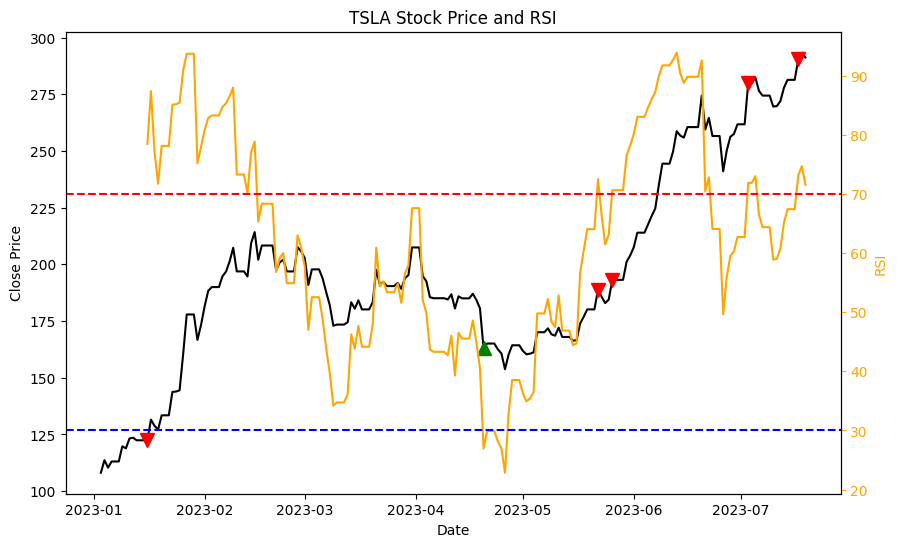

In [29]:
# plot simples utilizando matplotlib

fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(tsla_df.index, tsla_df['Close'], label='Close', color='black')

ax1.set_xlabel('Date')

ax1.set_ylabel('Close Price', color='black')

ax1.tick_params('y', colors='black')


ax2 = ax1.twinx()

ax2.plot(tsla_df.index, tsla_df['RSI'], label='RSI', color='orange')

ax2.set_ylabel('RSI', color='orange')

ax2.tick_params('y', colors='orange')


for index, row in tsla_df.iterrows():

    if row['Signal'] == 'BUY':

        ax1.plot(index, row['Close'], 'g^', markersize=10)

    elif row['Signal'] == 'SELL':

        ax1.plot(index, row['Close'], 'rv', markersize=10)


ax2.axhline(y=30, color='blue', linestyle='--', label='RSI 30')

ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70')

plt.title('TSLA Stock Price and RSI')

plt.show()

In [30]:
# modificar para candle (candlestick) FEITO

In [31]:
len(tsla_df)

198

In [32]:
# velas vermelhas = fechamento menor do que o fechamento do dia anterior. velhas verdes = fechamento maior do que o fechamento do dia anterior.
# velas ocas = fechamento maior do que a abertura. velas sólidas = fechamento menor do que a abertura

In [33]:
# plot interativo utilizando plotly. Divido em velas e rsi mas ainda sem as sinalizações

tsla_df["previousClose"] = tsla_df["Close"].shift(1)


tsla_df["color"] = np.where(tsla_df["Close"] > tsla_df["previousClose"], "green", "red")


tsla_df["fill"] = np.where(tsla_df["Close"] > tsla_df["Open"], "rgba(255, 0, 0, 0)", tsla_df["color"])


fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in tsla_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["Open"]],
            high=[row["High"]],
            low=[row["Low"]],
            close=[row["Close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=tsla_df.index, y=tsla_df['RSI'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


fig.update_layout(title="TSLA Stock Price and RSI (Last 14 days)",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()

In [34]:
# Melhoria do plot anterior, agora com sinalizações de compra e venda

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in tsla_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["Open"]],
            high=[row["High"]],
            low=[row["Low"]],
            close=[row["Close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=tsla_df.index, y=tsla_df['RSI'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in tsla_df.iterrows():
    if row['Signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['Signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="TSLA Stock Price and RSI (Last 14 days)",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()

In [35]:
tsla_df[tsla_df.index == '2023-05-21']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill
2023-05-21,177.169998,181.949997,176.309998,180.139999,180.139999,136024200.0,64.044871,HOLD,NaN,Range,180.139999,red,"rgba(255, 0, 0, 0)"


In [36]:
tsla_df[(tsla_df.index == '2023-05-21') & (tsla_df['RSI'] >= 70)]

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill


In [37]:
tsla_df[tsla_df['Signal'] != 'HOLD']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill
2023-01-16,116.550003,122.629997,115.599998,122.400002,122.400002,180714100.0,78.438027,SELL,NaN,Range,122.400002,red,"rgba(255, 0, 0, 0)"
2023-04-20,166.169998,169.699997,160.559998,162.990005,162.990005,210970800.0,26.924020,BUY,NaN,Range,180.589996,red,red
2023-05-22,180.699997,189.320007,180.110001,188.869995,188.869995,132001400.0,72.498857,SELL,NaN,Range,180.139999,green,"rgba(255, 0, 0, 0)"
2023-05-26,184.619995,198.600006,184.529999,193.169998,193.169998,162061500.0,70.626125,SELL,NaN,Range,184.470001,green,"rgba(255, 0, 0, 0)"
2023-07-03,276.489990,284.250000,275.109985,279.820007,279.820007,119685900.0,71.860982,SELL,NaN,Range,261.769989,green,"rgba(255, 0, 0, 0)"
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600.0,73.117890,SELL,NaN,Range,281.380005,green,"rgba(255, 0, 0, 0)"


**Melhorias da reunião 25 Janeiro**

In [38]:
# rsi separado do plot principal (gráfico) > makesubplot(para plotar grafico principal em cima e rsi embaixo)  FEITO

In [39]:
# plotly (graficos interativos) / dash (mesma coisa) > desenvolvimento web FEITO

In [40]:
# analisar tendencia (calculo simples de ema ou sma) FALTA

In [41]:
# utilizar ap iq (50 a 100 velas) >> get_candles (! Nao pega a do momento atual no montante !). estrutura de deck (nao array). Nao sobrescreve o candle (entao tem que passar um loop na chamada de funcao) FEITO

In [42]:
# colocar minha senha e email num .env FEITO

# **Plot a partir da iqoption (com indicador técnico RSI a partir de funcao propria)**

(https://medium.com/@maxwell.langford/its-2023-stop-leaking-secrets-in-google-colab-part-2-8215d47a76f2)



In [43]:
# o arquivo .env já deve estar montado no ambiente de execução a partir dessa célula

In [44]:
load_dotenv()

False

In [45]:
iqoption_email = os.getenv("my_email")

In [46]:
iqoption_password = os.getenv("my_password")

In [47]:
# logando na conta iqoption atráves da api iqoption

In [48]:
logging.basicConfig(level=logging.DEBUG,format='%(asctime)s %(message)s')
Iq=IQ_Option('', '')

In [49]:
# checando resposta da requisição

In [50]:
check, reason=Iq.connect()
print(check, reason)

True None


In [51]:
goal="EURUSD"

In [52]:
# pegando os valores das velas (lembrando que utiliza deck)
velas = Iq.get_candles(goal,60,111,time.time())

In [53]:
len(velas)

111

In [54]:
type(velas)

list

In [55]:
velas[0]

{'id': 2367275,
 'from': 1709229120,
 'at': 1709229180000000000,
 'to': 1709229180,
 'open': 1.079785,
 'close': 1.07993,
 'min': 1.079755,
 'max': 1.07993,
 'volume': 118}

In [56]:
velas[-1]

{'id': 2367385,
 'from': 1709235720,
 'at': 1709235722004338237,
 'to': 1709235780,
 'open': 1.080455,
 'close': 1.080465,
 'min': 1.080455,
 'max': 1.080465,
 'volume': 4}

In [57]:
EURUSD_df = pd.DataFrame(velas)

**Checando valores faltantes no dataframe originado**

In [58]:
EURUSD_df.head()

,id,from,at,to,open,close,min,max,volume
0,2367275,1709229120,1709229180000000000,1709229180,1.079785,1.079930,1.079755,1.079930,118
1,2367276,1709229180,1709229240000000000,1709229240,1.079925,1.079995,1.079925,1.080040,110
2,2367277,1709229240,1709229300000000000,1709229300,1.080000,1.080060,1.079995,1.080090,117
3,2367278,1709229300,1709229360001236569,1709229360,1.080060,1.079990,1.079965,1.080065,114
4,2367279,1709229360,1709229420000000000,1709229420,1.079990,1.079925,1.079830,1.079990,115


In [59]:
EURUSD_df.isna().sum()

id        0
from      0
at        0
to        0
open      0
close     0
min       0
max       0
volume    0
dtype: int64

In [60]:
rsi_values_2 = calculate_rsi(EURUSD_df['close'])

In [61]:
EURUSD_df['rsi'] = rsi_values_2

In [62]:
EURUSD_df['rsi'].isna().sum()

13

In [63]:
EURUSD_df['signal'] = generate_signals(EURUSD_df['rsi'])

In [64]:
EURUSD_df['signal'].isna().sum()

0

In [65]:
EURUSD_df['signal'].unique()

array(['HOLD', 'SELL', 'BUY'], dtype=object)

In [66]:
EURUSD_df["previousClose"] = EURUSD_df["close"].shift(1)


EURUSD_df["color"] = np.where(EURUSD_df["close"] > EURUSD_df["previousClose"], "green", "red")


EURUSD_df["fill"] = np.where(EURUSD_df["close"] > EURUSD_df["open"], "rgba(255, 0, 0, 0)", EURUSD_df["color"])

In [67]:
EURUSD_df[["previousClose", "color", "fill"]].isna().sum()

previousClose    1
color            0
fill             0
dtype: int64

**Checando valores únicos presentes no dataframe**

In [68]:
EURUSD_df["color"].unique()

array(['red', 'green'], dtype=object)

In [69]:
EURUSD_df["fill"].unique()

array(['rgba(255, 0, 0, 0)', 'red'], dtype=object)

In [70]:
# Plot a partir do dataframe gerado com dados requisitado da api iqoption. Possui sinalização básica utilizando apenas limiares de rsi

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in EURUSD_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"])) # TA FALTANDO O FILL NO DICIONARIO E PRONTO!
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["open"]],
            high=[row["max"]],
            low=[row["min"]],
            close=[row["close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['rsi'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in EURUSD_df.iterrows():
    if row['signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="EURUSD",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()

**Melhorias da reunião 15 fevereiro**

In [71]:
# candles definidas pelo plotly, nao necessaria coluna no df FEITO

In [72]:
# candle cinza quando fechamento igual a abertura FEITO

In [73]:
# iq get techinical indicator documentacao api FEITO

In [74]:
# usar ema FEITO

In [75]:
# combinar rsi com ema FEITO

In [76]:
# usar pivots (suporte resistencia) fibonacci (pontos compra ou venda) principais sao os mais proximos de 50 < o cara do mercadO FALTA

In [77]:
# fazer as entradas FALTA

# **Plot sem definir colunas de cor e fill anteriores no dataframe e plot com velas cinzas**

(https://medium.com/@lucasjamar47/advanced-tips-for-candlestick-plots-in-python-66977793bee)

(https://tradingqna.com/t/what-is-this-grey-candle-in-my-candlestick-chart/16296)

In [78]:
# Melhoria do plot anterior, agora sem utilizar colunas adicionais no dataframe dos valores de registros

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in EURUSD_df.iterrows():
    color = 'green' if row["close"] > row["previousClose"] else 'red'
    fill_color = 'rgba(255, 0, 0, 0)' if row["close"] > row["open"] else color
    coloring = dict(fillcolor=fill_color, line=dict(color=color))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["open"]],
            high=[row["max"]],
            low=[row["min"]],
            close=[row["close"]],
            increasing=coloring,
            decreasing=coloring,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['rsi'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in EURUSD_df.iterrows():
    if row['signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="EURUSD",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()

In [79]:
# velas cinzas sao definidas quando o fechamento do candle atual é igual ao fechamento do anterior

In [80]:
# Melhoria do plot anterior agora adicionando velas cinzas (nao houve nesse caso específico)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in EURUSD_df.iterrows():
    if row["close"] == row["previousClose"]:
        color = 'gray'
        fill_color = 'rgba(0, 0, 0, 0)'
    else:
        color = 'green' if row["close"] > row["previousClose"] else 'red'
        fill_color = 'rgba(255, 0, 0, 0)' if row["close"] > row["open"] else color
    coloring = dict(fillcolor=fill_color, line=dict(color=color))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["open"]],
            high=[row["max"]],
            low=[row["min"]],
            close=[row["close"]],
            increasing=coloring,
            decreasing=coloring,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['rsi'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in EURUSD_df.iterrows():
    if row['signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="EURUSD",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()


In [81]:
# Plot utilizando a mesma lógica do anterior (presença de velas cinzas) apenas para demonstrar o funcionamento

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))

for index, row in tsla_df.iterrows():
    if row["Close"] == row["previousClose"]:
        color = 'gray'
        fill_color = 'rgba(0, 0, 0, 0)'  # Define o fill color como transparente para os candles cinzas
    else:
        color = 'green' if row["Close"] > row["previousClose"] else 'red'
        fill_color = 'rgba(255, 0, 0, 0)' if row["Close"] > row["Open"] else color
    coloring = dict(fillcolor=fill_color, line=dict(color=color))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["Open"]],
            high=[row["High"]],
            low=[row["Low"]],
            close=[row["Close"]],
            increasing=coloring,
            decreasing=coloring,
            showlegend=False,
        ),
        row=1, col=1
    )

fig.add_trace(
    go.Scatter(x=tsla_df.index, y=tsla_df['RSI'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)

for index, row in tsla_df.iterrows():
    if row['Signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['Signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )

fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")

fig.update_layout(title="TSLA Stock Price and RSI (Last 14 days)",
                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))

fig.show()



# Retornando indíces técnicos diretamente da api iqoption (rsi, fibonacci e ema)

(https://iqoptionapi.github.io/iqoptionapi/en/techinical%20analysis/)

(https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema#:~:text=Exponential%20Moving%20Average%20(EMA)%20is,data%20that%20is%20more%20current.)

(https://www.investopedia.com/terms/e/ema.asp)

(https://capital.com/exponential-moving-average#:~:text=To%20read%20the%20EMA%20indicator,of%20the%20prevailing%20market%20conditions.)

(https://www.tradingpedia.com/forex-trading-strategies/forex-trading-strategy-8-a-combination-of-rsi-ema-and-candlestick-setups/)

In [82]:
indicators = Iq.get_technical_indicators(goal)

In [83]:
type(indicators)

list

In [84]:
indicators_df = pd.DataFrame(indicators)

In [85]:
indicators_df['name'].unique()

array(['Relative Strength Index (14)', 'Stochastic %K (14, 3, 3)',
       'Commodity Channel Index (20)', 'Average Directional Index (14)',
       'Awesome Oscillator', 'Momentum (10)', 'MACD Level (12, 26)',
       'Stochastic RSI Fast (3, 3, 14, 14)',
       'Williams Percent Range (14)', 'Bull Bear Power',
       'Ultimate Oscillator (7, 14, 28)',
       'Exponential Moving Average (5)', 'Simple Moving Average (5)',
       'Exponential Moving Average (10)', 'Simple Moving Average (10)',
       'Exponential Moving Average (20)', 'Simple Moving Average (20)',
       'Exponential Moving Average (30)', 'Simple Moving Average (30)',
       'Exponential Moving Average (50)', 'Simple Moving Average (50)',
       'Exponential Moving Average (100)', 'Simple Moving Average (100)',
       'Exponential Moving Average (200)', 'Simple Moving Average (200)',
       'Ichimoku Cloud Base Line (9, 26, 52, 26)',
       'Volume Weighted Moving Average (20)', 'Hull Moving Average (9)',
       'Classic s

In [86]:
indicators_df[indicators_df['name'].str.contains('Fibonacci')]

,action,candle_size,group,name,value
35,hold,60,PIVOTS,Fibonacci s3,1.075908
36,hold,60,PIVOTS,Fibonacci s2,1.078210
37,hold,60,PIVOTS,Fibonacci s1,1.079632
38,hold,60,PIVOTS,Fibonacci p,1.081933
39,hold,60,PIVOTS,Fibonacci r1,1.084235
40,hold,60,PIVOTS,Fibonacci r2,1.085657
41,hold,60,PIVOTS,Fibonacci r3,1.087958
92,hold,300,PIVOTS,Fibonacci s3,1.075907
93,hold,300,PIVOTS,Fibonacci s2,1.078208
94,hold,300,PIVOTS,Fibonacci s1,1.079630


**Plot rsi**

In [87]:
rsi_df = indicators_df[indicators_df['name'] == 'Relative Strength Index (14)'].reset_index(drop=True)

In [88]:
rsi_df.head()

,action,candle_size,group,name,value
0,hold,60,OSCILLATORS,Relative Strength Index (14),33.759125
1,hold,300,OSCILLATORS,Relative Strength Index (14),46.422897
2,hold,900,OSCILLATORS,Relative Strength Index (14),38.657524
3,hold,3600,OSCILLATORS,Relative Strength Index (14),38.920628
4,hold,14400,OSCILLATORS,Relative Strength Index (14),42.573433


In [89]:
rsi_df.shape

(8, 5)

In [90]:
#Plot com os pontos marcados definindo os momentos de entrada. Os de hold como cinza, buy verde e sell vermelho

fig = go.Figure()


fig.add_trace(
    go.Scatter(x=rsi_df.index, y=rsi_df['value'], mode='lines', name='RSI', marker=dict(color='orange'))
)


for index, row in rsi_df.iterrows():

    in_overbought = False

    in_oversold = False

    if row['value'] >= 70 and not in_overbought:

      color = 'red'

      in_overbought = True

      in_oversold = False

    elif row['value'] <= 30 and not in_oversold:

      color = 'green'

      in_oversold = True

      in_overbought = False

    else:

      color = 'grey'

      in_oversold = False

      in_overbought = False


    fig.add_trace(
        go.Scatter(
            x=[index],
            y=[row['value']],
            mode="markers",
            marker=dict(color=color),
            showlegend=False
        )
    )


fig.update_layout(
    title="Valores (RSI) em relação ao Candle Size",
    xaxis_title="Candle Size",
    yaxis_title="Valor (RSI)"
)

fig.update_yaxes(range=[0, 100])

fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.show()

**Plot ema**

The EMA focused more on recent price moves, which means it tends to respond more quickly to price changes than the SMA

lembrando que a principal diferença entre ema e sma é que ema possui maior sensibilidade aos registros mais recentes.

This can be a double-edged sword. On one side, it can help you identify trends earlier than an SMA would. On the flip side, the EMA will probably experience more short-term changes than a corresponding SMA.

Like all moving average indicators, EMAs are much better suited for trending markets

"The 12- and 26-day exponential moving averages (EMAs) are often the most quoted and analyzed short-term averages"

"short-term investors tend to use 8- and 20-day EMAs"

EMA Sloping Upward and Below Price (Bullish): Indicates bullish momentum, suggesting that the price is likely to continue rising. This is considered a strong bullish signal.

EMA Sloping Upward and Above Price (Bullish with Resistance): While still bullish, the presence of the EMA above the price suggests increased resistance. It indicates that although the trend is bullish, there might be some resistance levels overhead that could slow down or halt the upward movement.

EMA Sloping Downward and Above Price (Bearish): Indicates a bearish trend, suggesting that the price is likely to continue falling. This is considered a strong bearish signal.

EMA Sloping Downward and Below Price (Bearish with Resistance): While still bearish, the presence of the EMA below the price suggests resistance to further downward movement. It indicates that although the trend is bearish, there might be some support levels below the price that could slow down or halt the downward movement.

In [91]:
ema_20_df = indicators_df[indicators_df['name'] == 'Exponential Moving Average (20)'].reset_index(drop=True)

In [92]:
ema_20_df.head()

,action,candle_size,group,name,value
0,sell,60,MOVING AVERAGES,Exponential Moving Average (20),1.080757
1,sell,300,MOVING AVERAGES,Exponential Moving Average (20),1.080692
2,sell,900,MOVING AVERAGES,Exponential Moving Average (20),1.081254
3,sell,3600,MOVING AVERAGES,Exponential Moving Average (20),1.082534
4,sell,14400,MOVING AVERAGES,Exponential Moving Average (20),1.082949


In [93]:
ema_20_df.shape

(8, 5)

In [94]:
#Plot com os pontos marcados definindo os momentos de entrada. Os de hold como cinza, buy verde e sell vermelho (EMA 20)

fig = go.Figure()


fig.add_trace(
    go.Scatter(x=ema_20_df.index, y=ema_20_df['value'], mode='lines', name='RSI', marker=dict(color='orange'))
)


for index, row in ema_20_df.iterrows():

    if row['action'] == 'buy':

      color = 'green'

    elif row['action'] == 'sell':

      color = 'red'

    else:

      color = 'grey'


    fig.add_trace(
        go.Scatter(
            x=[index],
            y=[row['value']],
            mode="markers",
            marker=dict(color=color),
            showlegend=False
        )
    )


fig.update_layout(
    title="Valores (EMA 20) em relação ao Candle Size",
    xaxis_title="Candle Size",
    yaxis_title="Valor (EMA 20)"
)


fig.show()

In [95]:
# lidando agora com cálculo de ema para 5 dias

In [96]:
ema_5_df = indicators_df[indicators_df['name'] == 'Exponential Moving Average (5)'].reset_index(drop=True)

In [97]:
ema_5_df.head()

,action,candle_size,group,name,value
0,sell,60,MOVING AVERAGES,Exponential Moving Average (5),1.080634
1,sell,300,MOVING AVERAGES,Exponential Moving Average (5),1.080727
2,sell,900,MOVING AVERAGES,Exponential Moving Average (5),1.080669
3,sell,3600,MOVING AVERAGES,Exponential Moving Average (5),1.081141
4,sell,14400,MOVING AVERAGES,Exponential Moving Average (5),1.081917


In [98]:
ema_5_df.shape

(8, 5)

In [99]:
#Plot com os pontos marcados definindo os momentos de entrada. Os de hold como cinza, buy verde e sell vermelho (EMA 5)

fig = go.Figure()


fig.add_trace(
    go.Scatter(x=ema_5_df.index, y=ema_5_df['value'], mode='lines', name='RSI', marker=dict(color='orange'))
)


for index, row in ema_5_df.iterrows():

    if row['action'] == 'buy':

      color = 'green'

    elif row['action'] == 'sell':

      color = 'red'

    else:

      color = 'grey'


    fig.add_trace(
        go.Scatter(
            x=[index],
            y=[row['value']],
            mode="markers",
            marker=dict(color=color),
            showlegend=False
        )
    )


fig.update_layout(
    title="Valores (EMA 5) em relação ao Candle Size",
    xaxis_title="Candle Size",
    yaxis_title="Valor (EMA 5)"
)


fig.show()

**Combinando RSI e EMA (tanto ema 20 quanto 5)**

In [100]:
# Plot combinando os valores de RSI, EMA (tanto ema 20 quanto 5)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("EMA (5 e 20 períodos)", "RSI"))

fig.add_trace(go.Scatter(x=ema_20_df.index, y=ema_20_df['value'], mode='lines', name='EMA 20', line=dict(color='blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=ema_5_df.index, y=ema_5_df['value'], mode='lines', name='EMA 5', line=dict(color='green')), row=1, col=1)

fig.update_xaxes(title_text="Candle Size", row=1, col=1)
fig.update_yaxes(title_text="Valor", row=1, col=1)

fig.add_trace(go.Scatter(x=rsi_df.index, y=rsi_df['value'], mode='lines', name='RSI', line=dict(color='orange')), row=2, col=1)

fig.update_xaxes(title_text="Candle Size", row=2, col=1)
fig.update_yaxes(title_text="Valor", row=2, col=1)

fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")

fig.update_layout(title="Valores de EMA (5 e 20 períodos) e RSI em relação ao Candle Size")

fig.show()



In [101]:
combinado_df = pd.concat([rsi_df[['candle_size', 'value']], ema_5_df['value'], ema_20_df['value']], axis=1)

In [102]:
combinado_df.columns = ['candle_size', 'rsi', 'ema(5)', 'ema(20)']

In [103]:
combinado_df.head()

,candle_size,rsi,ema(5),ema(20)
0,60,33.759125,1.080634,1.080757
1,300,46.422897,1.080727,1.080692
2,900,38.657524,1.080669,1.081254
3,3600,38.920628,1.081141,1.082534
4,14400,42.573433,1.081917,1.082949


In [104]:
# Inicializando a coluna action como hold
combinado_df['action'] = 'hold'

In [105]:
# Defininco as ações de acordo com combinacao de rsi, ema(5) e ema(20)

for index, row in combinado_df.iterrows():


    if index > 0:

        rowanterior = combinado_df.iloc[index - 1]
    else:

        rowanterior = None

    if rowanterior is not None:

      if row['rsi'] > 50 and (row['ema(5)'] - row['ema(20)'] > 0 and rowanterior['ema(5)'] - rowanterior['ema(20)'] < 0):

        print(row[['rsi', 'ema(5)', 'ema(20)']])

        print("BUY!")

        combinado_df.loc[index, 'action'] = 'buy'

      elif row['rsi'] < 50 and (row['ema(5)'] - row['ema(20)'] < 0 and rowanterior['ema(5)'] - rowanterior['ema(20)'] > 0):

        print(row[['rsi', 'ema(5)', 'ema(20)']])

        print("SELL!")

        combinado_df.loc[index, 'action'] = 'sell'


rsi        38.657524
ema(5)      1.080669
ema(20)     1.081254
Name: 2, dtype: object
SELL!
rsi        48.94014
ema(5)     1.081659
ema(20)    1.083043
Name: 6, dtype: object
SELL!


In [106]:
combinado_df

,candle_size,rsi,ema(5),ema(20),action
0,60,33.759125,1.080634,1.080757,hold
1,300,46.422897,1.080727,1.080692,hold
2,900,38.657524,1.080669,1.081254,sell
3,3600,38.920628,1.081141,1.082534,hold
4,14400,42.573433,1.081917,1.082949,hold
5,86400,47.360661,1.082420,1.081485,hold
6,604800,48.940140,1.081659,1.083043,sell
7,2592000,48.714321,1.084026,1.082176,hold


**Melhorias da reunião 29 de fevereiro**

In [107]:
# implementar protective stop (de acordo com niveis de suporte?) < talvez possa ser utilizando fibonacci

# Entradas

In [108]:
# setar a conta para o tipo 'prática' para ter dinheiro de mentirinha para efetuar operações abaixo

balance_type = 'PRACTICE'
Iq.change_balance(balance_type)

In [109]:
Iq.get_balance()

10000

In [110]:
actions = list(combinado_df.action)
actions

['hold', 'hold', 'sell', 'hold', 'hold', 'hold', 'sell', 'hold']

In [111]:
# pegar dicionário com ativos abertos e fechados para compra no momento

ALL_Asset = Iq.get_all_open_time()

In [112]:
# retorna true quando aberto para compra e false do contrário

ALL_Asset['forex']['EURUSD']['open']

True

In [113]:
QUANTIA = 10
ATIVO = 'EURUSD'
AÇÃO = 'call'
EXPIRATIONS_MODE = 1

In [114]:
# buy

def comprar(QUANTIA, ATIVO, AÇÃO, EXPIRATIONS_MODE):
  print(f'saldo da conta pré operação: {Iq.get_balance()}')

  check, id = Iq.buy(QUANTIA, ATIVO, AÇÃO, EXPIRATIONS_MODE)
  if check:
    return f'tentativa de compra efetuada com sucesso, ' \
           f'id da operação: {id}, ' \
           f'saldo atual: {Iq.get_balance()}'

  else:
    return f'tentativa de compra efetuada sem sucesso, saldo atual: {Iq.get_balance()}'

In [115]:
# sell

from time import sleep

def vender(QUANTIA, ATIVO, AÇÃO, EXPIRATIONS_MODE):
  print(f'saldo da conta pré operação: {Iq.get_balance()}')

  vender = Iq.buy(QUANTIA, ATIVO, AÇÃO, EXPIRATIONS_MODE)

  a_vender = list()
  a_vender.append(vender)

  sleep(2)

  print('vendendo...')
  Iq.sell_option(a_vender)

  print(f'saldo atual: {Iq.get_balance()}')

In [116]:
# hold não é preciso fazer nada

def hold():
  print('🫸')

hold()

🫸


In [117]:
def chamar_operação(sinal):
    match sinal:
      case 'buy':
        print(comprar(QUANTIA=QUANTIA,
                      ATIVO=ATIVO,
                      AÇÃO=AÇÃO,
                      EXPIRATIONS_MODE=EXPIRATIONS_MODE))

      case 'sell':
        print(vender(QUANTIA=QUANTIA,
                      ATIVO=ATIVO,
                      AÇÃO=AÇÃO,
                      EXPIRATIONS_MODE=EXPIRATIONS_MODE))

      case 'hold':
        print(hold())

In [118]:
ativo = 'EURUSD'

def checar_e_efetuar(action, ativo=ativo):
  if ALL_Asset['forex'][ativo]['open']:
    print(f'{ativo} aberto para compra... prosseguindo...')

    chamar_operação(action)

  else:
    print(f'{ativo} fechado para compra... encerrando...')

  print('-' * 50)

In [119]:
actions

['hold', 'hold', 'sell', 'hold', 'hold', 'hold', 'sell', 'hold']

In [120]:
for action in actions:
  checar_e_efetuar(action)

EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 10000
vendendo...
saldo atual: 9990
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 9990
vendendo...
saldo atual: 9980
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------


In [121]:
# supondo o caso de uma lista com os três tipos de ações

actions_demostração = ['hold', 'buy', 'sell', 'hold', 'hold', 'buy', 'sell', 'hold']

In [122]:
for action_demostração in actions_demostração:
  checar_e_efetuar(action_demostração)

EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 9980
tentativa de compra efetuada com sucesso, id da operação: 11299144522, saldo atual: 9970
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 9970
vendendo...
saldo atual: 9960
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
🫸
None
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 9960
tentativa de compra efetuada com sucesso, id da operação: 11299144750, saldo atual: 9950
--------------------------------------------------
EURUSD aberto para compra... prosseguindo...
saldo da conta pré operação: 9950
vendendo.

In [123]:
# a fazer - if money > saldo throw exception

In [124]:
# a fazer - como descobrir a quantidade que tenho de EURUSD

In [125]:
# a fazer - de onde vem esse none

In [126]:
# a fazer - olhar se podemos inferir uma quantia otimizada para uso na compra e venda